# 📊 Model Selection Notebook
Este notebook unifica el preprocesamiento y la comparación de modelos para predecir el riesgo de ictus.
Incluye: limpieza, balanceo, comparación con validación cruzada y visualización de resultados.

In [2]:
# 📦 1. Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, f1_score

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Carga del dataset limpio
df = pd.read_csv("cleaned_dataset.csv")
df.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1,67.0,0,1,1,1,228.69,36.6,1,1,0,0,1,0,0
1,1,80.0,0,1,1,0,105.92,32.5,1,1,0,0,0,1,0
2,0,49.0,0,0,1,1,171.23,34.4,1,1,0,0,0,0,1
3,0,79.0,1,0,1,0,174.12,24.0,1,0,1,0,0,1,0
4,1,81.0,0,0,1,1,186.21,29.0,1,1,0,0,1,0,0


In [ ]:
# Preprocesado y balanceo con SMOTE

# Separamos variables y target
X = df.drop(columns=["stroke"])
y = df["stroke"]

# Separamos columnas numéricas y categóricas
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

# Preprocesado
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols)
])

# División en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Aplicación del preprocesamiento + SMOTE en el entrenamiento
X_train_processed = preprocessor.fit_transform(X_train)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

# Transformación del test sin aplicar SMOTE
X_test_processed = preprocessor.transform(X_test)


In [13]:
# --------------------------------------------------------
# COMPARACIÓN CON VALIDACIÓN CRUZADA (STRATIFIED K-FOLD)
# Modelos evaluados:
# - Logistic Regression
# - Random Forest
# - Support Vector Machine
# - Gradient Boosting
# - XGBoost
# --------------------------------------------------------

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
import pandas as pd

# Definimos los modelos a comparar
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Definimos los scorers
scoring = {
    "precision": make_scorer(precision_score),
    "recall": make_scorer(recall_score),
    "f1": make_scorer(f1_score)
}

# Creamos el validador cruzado estratificado
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Guardamos los resultados aquí
cv_results = {}

# Evaluamos cada modelo con validación cruzada
for name, model in models.items():
    scores = cross_validate(model, X_train_resampled, y_train_resampled, cv=cv, scoring=scoring)
    cv_results[name] = {
        "Precision": scores["test_precision"].mean(),
        "Recall": scores["test_recall"].mean(),
        "F1-score": scores["test_f1"].mean()
    }

# Convertimos los resultados a DataFrame
cv_df = pd.DataFrame(cv_results).T.sort_values("F1-score", ascending=False)
cv_df.style.background_gradient(cmap="Blues").format("{:.3f}")


,Precision,Recall,F1-score
Random Forest,0.943,0.973,0.958
XGBoost,0.950,0.948,0.949
Gradient Boosting,0.878,0.913,0.895
SVM,0.832,0.938,0.882
Logistic Regression,0.760,0.827,0.792


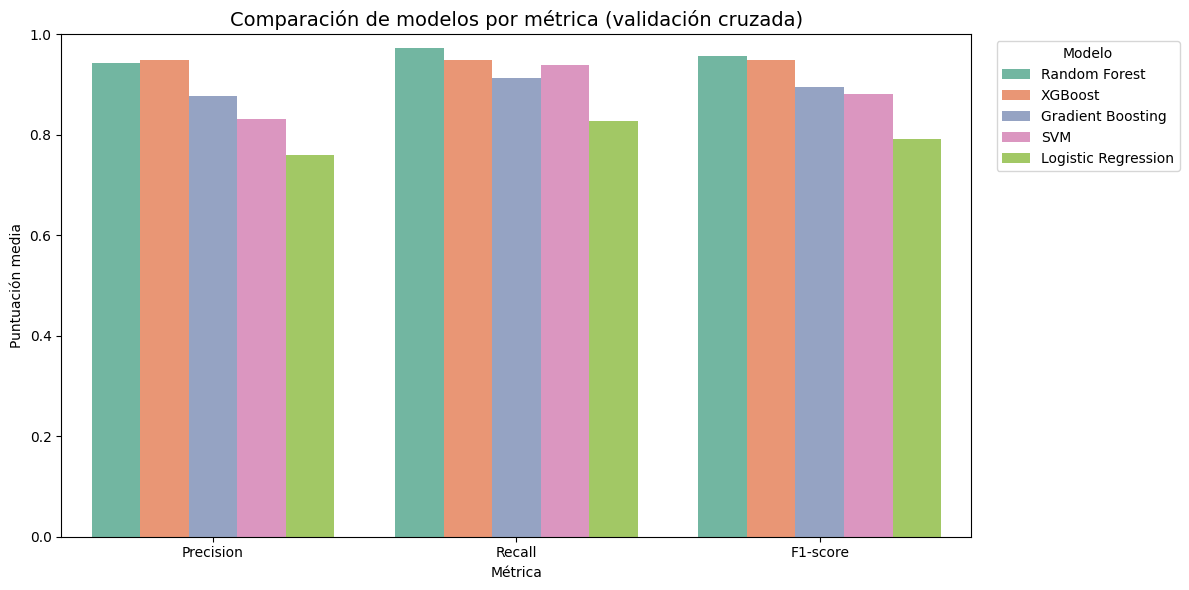

In [14]:
# --------------------------------------------------------
# VISUALIZACIÓN DE LA COMPARACIÓN DE MODELOS
# Representación gráfica de Precision, Recall y F1-score
# --------------------------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns

# Reestructuramos el DataFrame para usarlo en seaborn
cv_df_long = cv_df.reset_index().melt(
    id_vars="index", var_name="Métrica", value_name="Valor"
)
cv_df_long.rename(columns={"index": "Modelo"}, inplace=True)

# Gráfico de barras comparativo
plt.figure(figsize=(12, 6))
sns.barplot(data=cv_df_long, x="Métrica", y="Valor", hue="Modelo", palette="Set2")

plt.title("Comparación de modelos por métrica (validación cruzada)", fontsize=14)
plt.ylim(0, 1)
plt.ylabel("Puntuación media")
plt.xlabel("Métrica")
plt.legend(title="Modelo", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [16]:
# --------------------------------------------------------
# ENTRENAMIENTO FINAL DEL MEJOR MODELO + GUARDADO
# --------------------------------------------------------

from sklearn.ensemble import RandomForestClassifier
import joblib

# 1. Seleccionamos el mejor modelo (basado en la comparativa anterior)
best_model = RandomForestClassifier(random_state=42)

# 2. Entrenamos el modelo con TODOS los datos de entrenamiento (ya balanceados con SMOTE)
best_model.fit(X_train_resampled, y_train_resampled)

# 3. Guardamos el modelo en formato .pkl para uso posterior en API o frontend
joblib.dump(best_model, "cesar_model.pkl")

# OPCIONAL: guardar también el preprocesador si lo necesitas más adelante
# joblib.dump(preprocessor, "models/preprocessor.pkl")

print("✅ Modelo final entrenado y guardado correctamente.")


✅ Modelo final entrenado y guardado correctamente.
